c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 1586/1586 [00:00<00:00, 791547.61 examples/s]
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 6743.92 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_81820\2453943782.py:

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.086500,1.058311,0.408424,0.291180
2,1.065400,1.054540,0.419272,0.373871
3,1.062300,1.048360,0.418634,0.379127
4,1.088100,1.049076,0.410338,0.278864
5,1.076800,1.048084,0.425654,0.367334
6,1.092700,1.048035,0.412891,0.283363
7,1.018600,1.045210,0.423101,0.388565
8,1.059600,1.051365,0.423101,0.388400
9,1.009500,1.048802,0.435227,0.401252
10,1.011300,1.049540,0.434588,0.397585


Validation Results: {'eval_loss': 1.0452096462249756, 'eval_accuracy': 0.4231014677728143, 'eval_f1': 0.3885650633392134, 'eval_runtime': 8.4821, 'eval_samples_per_second': 184.742, 'eval_steps_per_second': 11.554, 'epoch': 10.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.49      0.07      0.12       361
    Positive       0.43      0.60      0.50       654
    Negative       0.41      0.45      0.43       571

    accuracy                           0.42      1586
   macro avg       0.44      0.37      0.35      1586
weighted avg       0.44      0.42      0.39      1586



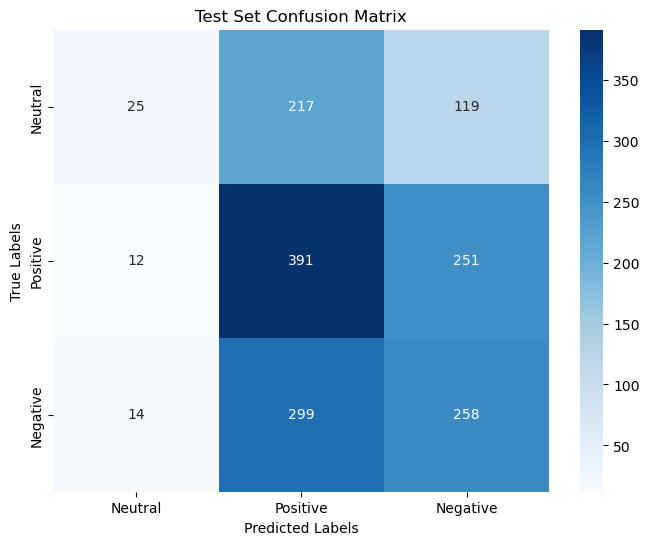

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          Trainer, TrainingArguments, EarlyStoppingCallback)

# Load datasets
train_df = pd.read_csv("data/Train.csv")
test_df = pd.read_csv("data/Test.csv")
val_df = pd.read_csv("data/Val.csv")

# Rename labels
label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
train_df["Label"] = train_df["Label"].map(label_mapping)
test_df["Label"] = test_df["Label"].map(label_mapping)
val_df["Label"] = val_df["Label"].map(label_mapping)

# Check for missing values and shuffle
def preprocess_df(df):
    df.dropna(inplace=True)
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df)
val_df = preprocess_df(val_df)

# Convert to Hugging Face dataset
def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Encode labels
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}

dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'albert/albert-base-v1'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[],
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_total_limit=3
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping
)

# Train model
trainer.train()

# Evaluate model on validation set
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Final evaluation on test set
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
